# Movie Genre Classification

Movies are a popular means of entertainment all around the world. With a lot of streaming services and websites available and with more on the horizon, building a predictive model that automatically generates the genre of a movie based on the its plot summary is definitely beneficial as it may reduce the expense of manually tagging the movies.

# Data Understanding

## Preprocessing and Exploratory Data Analysis

#### Import needed packages


In [1]:
import pandas as pd
import re
import nltk
from sklearn.svm import SVC
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from num2words import num2words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


[nltk_data] Downloading package punkt to /Users/lilia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/lilia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/lilia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Data Information

In [2]:
# Loading the dataset
dataset_path = 'data/train_data.txt'
data = pd.read_csv(dataset_path, sep=':::', engine='python', header=None)
data.columns = ['ID', 'TITLE', 'GENRE', 'DESCRIPTION']

In [3]:
print('Number of instances = %d' % (data.shape[0]))
print('Number of attributes = %d' % (data.shape[1]))
data.head()

Number of instances = 54214
Number of attributes = 4


,ID,TITLE,GENRE,DESCRIPTION
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


#### Data Types

In [4]:
# Printing data types of DataFrame
data.dtypes

ID              int64
TITLE          object
GENRE          object
DESCRIPTION    object
dtype: object

#### Dataframe Statistics

In [5]:
# Printing description of DataFrame
data.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,54214.0,27107.5,15650.378084,1.0,13554.25,27107.5,40660.75,54214.0


### Extract unique values of GENRE feature


In [6]:
# Extract unique genres
unique_genres = data['GENRE'].unique()
# Total number of unique genres
# Calculate frequency of each genre
genre_counts = data['GENRE'].value_counts()
total_unique_genres = len(genre_counts)


# Print total number of unique genres
print(f"Total number of unique genres/classes: {total_unique_genres}")

Total number of unique genres/classes: 27


### Print them with their frequency

In [7]:
# Print unique genres and their counts
print("\nUnique genres/classes in the 'Genre' attribute and their counts:")
for genre, count in genre_counts.items():
    print(f"{genre}: {count}")


Unique genres/classes in the 'Genre' attribute and their counts:
 drama : 13613
 documentary : 13096
 comedy : 7447
 short : 5073
 horror : 2204
 thriller : 1591
 action : 1315
 western : 1032
 reality-tv : 884
 family : 784
 adventure : 775
 music : 731
 romance : 672
 sci-fi : 647
 adult : 590
 crime : 505
 animation : 498
 sport : 432
 talk-show : 391
 fantasy : 323
 mystery : 319
 musical : 277
 biography : 265
 history : 243
 game-show : 194
 news : 181
 war : 132


### Plot them with their distribution

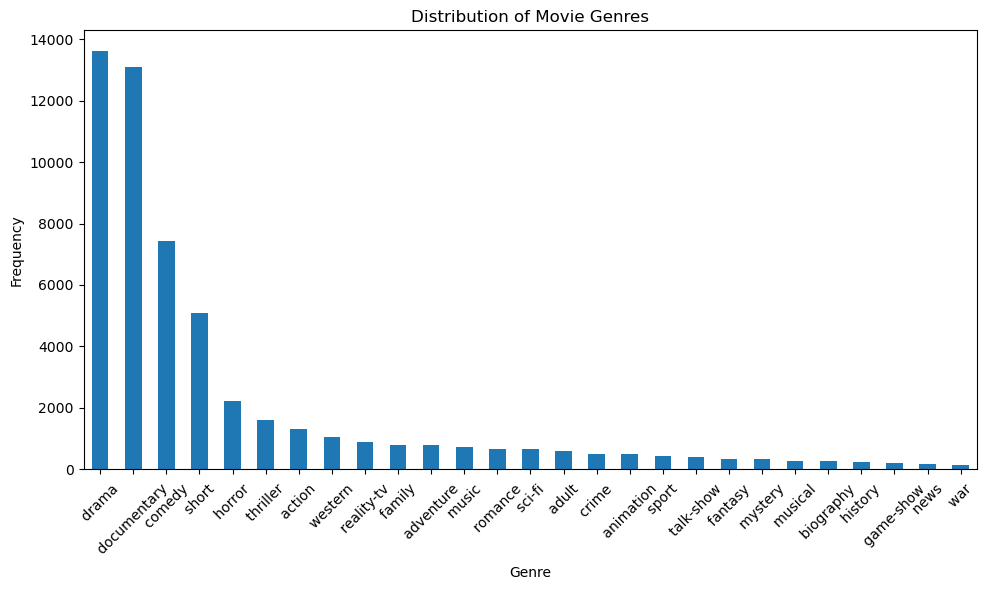

In [8]:
# Plotting
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar')
plt.title('Distribution of Movie Genres')
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#           Data Cleaning and Standardization

 ### Removing HTML tags if the data is scraped from the web

In [9]:
def remove_html_tags(text):
    clean_text = re.sub(r'<[^>]+>', '', text)
    return clean_text


 ### Removing special characters

In [10]:
def remove_special_characters(text):
    clean_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return clean_text


 ### Removing emojis and  non-standard symbols

In [11]:
# Define a regex pattern to match emojis and non-standard symbols
# This pattern targets characters outside the typical ASCII range, which includes most emojis and non-standard symbols
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"  # Dingbats
                           u"\U000024C2-\U0001F251"  # Enclosed characters
                           "]+", flags=re.UNICODE)

# Function to remove emojis and non-standard symbols
def remove_emojis_and_symbols(text):
    return emoji_pattern.sub(r'', text)

# Apply the function to remove emojis and non-standard symbols from DESCRIPTION
data['DESCRIPTION'] = data['DESCRIPTION'].apply(remove_emojis_and_symbols)

###   Converting to Lowercase:

In [12]:
 # Convert DESCRIPTION column to lowercase
data['DESCRIPTION'] = data['DESCRIPTION'].str.lower()


### Fixing Encoding Issues

In [13]:
try:
    data = pd.read_csv('data/train_data.txt', 
                       sep=':::', 
                       engine='python',
                       encoding='utf-8',  # Ensure UTF-8 encoding
                       on_bad_lines='skip',
                       quotechar='"', 
                       names=['ID', 'TITLE', 'GENRE', 'DESCRIPTION']
                      )
    print("Data loaded successfully.")
except Exception as e:
    print(f"An error occurred: {e}")

Data loaded successfully.


###  Remove Extra Whitespace

In [14]:
def remove_extra_whitespace(text):
    words = text.split()
    clean_words = [word.strip() for word in words]
    clean_text = ' '.join(clean_words)
    return clean_text

# Apply the function to the DESCRIPTION column
data['CLEAN_DESCRIPTION'] = data['DESCRIPTION'].apply(remove_extra_whitespace)


### Handle Missing Values

In [15]:
# Handle missing values
data.dropna(inplace=True)

# Check for missing values
assert not data.isnull().values.any(), "Missing values are present in the data."

# Print success message
print("Missing values handled successfully.")


Missing values handled successfully.


### Normalization

In [16]:
# Define function to normalize numbers in a column
def normalize_numbers_column(column):
    number_pattern = r'\b\d[\d,.]*\b'
    return column.str.replace(number_pattern, 'NUMBER', regex=True)

### Non-informative words

In [17]:
df = pd.DataFrame(data)
# Download the set of stop words the first time
nltk.download('stopwords')

# Load the stop words
non_informative_words = set(stopwords.words('english'))

# Define the function to remove non-informative words
def remove_non_informative(text):
    # Split the text into words and remove non-informative words
    return ' '.join(word for word in text.split() if word.lower() not in non_informative_words)

# Assuming 'df' is your DataFrame and it has a column 'CLEAN_DESCRIPTION'
# Apply the function to remove non-informative words from 'CLEAN_DESCRIPTION'
df['CLEAN_DESCRIPTION'] = df['CLEAN_DESCRIPTION'].apply(remove_non_informative)

# Check again for non-informative words in 'CLEAN_DESCRIPTION'
df['contains_non_informative'] = df['CLEAN_DESCRIPTION'].apply(
    lambda x: any(word.lower() in non_informative_words for word in x.split())
)

# Display the DataFrame to verify the removal
display_df = df[['CLEAN_DESCRIPTION', 'contains_non_informative']]

# Summarize the checks
summary = {
    'Non-informative Words Removed': not df['contains_non_informative'].any()
}

summary


[nltk_data] Downloading package stopwords to /Users/lilia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'Non-informative Words Removed': True}

### checking cleanliness

In [18]:
# Get the length of the DESCRIPTION column before removing HTML tags
original_length = len(data['DESCRIPTION'])

# Apply the function to remove HTML tags
data['DESCRIPTION'] = data['DESCRIPTION'].apply(remove_html_tags)
# Get the length of the DESCRIPTION column after removing HTML tags
cleaned_length = len(data['DESCRIPTION'])

# Check if the lengths are different
if original_length != cleaned_length:
    print("HTML tags were present and successfully removed.")
else:
    print("No HTML tags were found in the DESCRIPTION column.")


No HTML tags were found in the DESCRIPTION column.


In [19]:
# Get the length of the DESCRIPTION column before removing HTML tags
original_length = len(data['DESCRIPTION'])

# Apply the function to remove HTML tags
data['DESCRIPTION'] = data['DESCRIPTION'].apply(remove_special_characters)
# Get the length of the DESCRIPTION column after removing HTML tags
cleaned_length = len(data['DESCRIPTION'])

# Check if the lengths are different
if original_length != cleaned_length:
    print("Special characters were present and successfully removed.")
else:
    print("No Special characters were found in the DESCRIPTION column.")


No Special characters were found in the DESCRIPTION column.


In [20]:
# Get the length of the DESCRIPTION column before removing HTML tags
original_length = len(data['DESCRIPTION'])

# Apply the function to remove HTML tags
data['DESCRIPTION'] = data['DESCRIPTION'].apply(remove_emojis_and_symbols
)
# Get the length of the DESCRIPTION column after removing HTML tags
cleaned_length = len(data['DESCRIPTION'])

# Check if the lengths are different
if original_length != cleaned_length:
    print("emojis and symbols were present and successfully removed.")
else:
    print("No emojis and symbols were found in the DESCRIPTION column.")


No emojis and symbols were found in the DESCRIPTION column.


In [21]:
def convert_to_lowercase(text):
    return text.lower()

# Apply the function to the DESCRIPTION column
data['CLEAN_DESCRIPTION'] = data['DESCRIPTION'].apply(convert_to_lowercase)

# Check if all text is converted to lowercase
is_lowercase = (data['DESCRIPTION'].str.lower() == data['CLEAN_DESCRIPTION']).all()

if is_lowercase:
    print("All text in the CLEAN_DESCRIPTION column is in lowercase.")
else:
    print("Not all text in the CLEAN_DESCRIPTION column is in lowercase.")


All text in the CLEAN_DESCRIPTION column is in lowercase.


### Handling Numbers

In [22]:
# Function to handle numbers (convert contextually relevant numbers to words and removes irrelevant ones.)
def handle_numbers(text):

    # Convert years to text (years often signify important context in movies)
    clean_text = re.sub(r'\b(17|20)\d{2}\b', lambda match: num2words(match.group()), text)
    
    # Convert significant numbers to text if they are relevant to your analysis.
    clean_text = re.sub(r'\b\d{1,2}\b', lambda match: num2words(match.group()), text)
    
    # Remove remaining numbers that might not be relevant
    clean_text = re.sub(r'\b\d+\b', '', text)
    
    return clean_text

# Applying the preprocessing function to the 'DESCRIPTION' column
data['CLEAN_DESCRIPTION'] = data['CLEAN_DESCRIPTION'].apply(handle_numbers)

### Tokenization, Stop Words Removal, and Handling Negations:

In [23]:
# Tokenization, Stop Words Removal, and Handling Negations
def preprocess_text(text):
    
    # Removing non-alphanumeric characters
    # This to make sure that we do not have like (film, 's, instead we will have films)
    text = ''.join(char for char in text if char.isalnum() or char.isspace())
    
    # Tokenizing the description
    tokens = word_tokenize(text)

    # Removing stop words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]

    # Handling negations (e.g., "not good" becomes "not_good")
    for i in range(len(filtered_tokens)):
        if filtered_tokens[i] == 'not' and i + 1 < len(filtered_tokens):
            filtered_tokens[i + 1] = 'not_' + filtered_tokens[i + 1]

    return filtered_tokens

# Applying the preprocessing function to the 'DESCRIPTION' column
data['TOKENIZED_DESCRIPTION'] = data['CLEAN_DESCRIPTION'].apply(preprocess_text)

### Stemming

In [24]:
# Initialize the Snowball Stemmer for English
snowball_stemmer = SnowballStemmer("english")

# Function to stem a list of tokens using the Snowball Stemmer, returns stemmed tokens
def stem_tokens_snowball(tokenized_text):
    # Stem each token in the list using the Snowball Stemmer
    stemmed_tokens = [snowball_stemmer.stem(token) for token in tokenized_text]
    return stemmed_tokens

# Applying the stemming function with Snowball Stemmer to the 'TOKENIZED_DESCRIPTION' column
data['STEMMED_DESCRIPTION'] = data['TOKENIZED_DESCRIPTION'].apply(stem_tokens_snowball)

### Lemmatization

In [25]:
# Function to lemmatize a list of tokens , returns a lemmatized token
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    # Lemmatize each token
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens

# Applying the Lemmatization function to the 'STEMMED_DESCRIPTION' column
data['LEMMATIZED_DESCRIPTION'] = data['STEMMED_DESCRIPTION'].apply(lemmatize_tokens)

## Summary

In [26]:
# Assuming 'data' is your DataFrame and it has a column 'CLEAN_DESCRIPTION'
df = pd.DataFrame(data)

# 1. Check for HTML tags
html_tag_pattern = re.compile(r'<[^>]+>')
df['contains_html_tags'] = df['CLEAN_DESCRIPTION'].apply(lambda x: bool(html_tag_pattern.search(x)))

# 2. Check for special characters
special_chars_pattern = re.compile(r'[@#$%]')
df['contains_special_chars'] = df['CLEAN_DESCRIPTION'].apply(lambda x: bool(special_chars_pattern.search(x)))

# 3. Check for non-standard symbols or emojis
non_standard_pattern = re.compile(r'[^\w\s,.!?;:\-\(\)\'\"/]')
df['contains_non_standard_symbols'] = df['CLEAN_DESCRIPTION'].apply(lambda x: bool(non_standard_pattern.search(x)))

# 4. Check for lowercase text
df['is_lowercase'] = df['CLEAN_DESCRIPTION'].apply(lambda x: x.islower())

# 5 Apply the function to remove non-informative words from 'CLEAN_DESCRIPTION'
df['CLEAN_DESCRIPTION'] = df['CLEAN_DESCRIPTION'].apply(remove_non_informative)

# Check again for non-informative words in 'CLEAN_DESCRIPTION'
df['contains_non_informative'] = df['CLEAN_DESCRIPTION'].apply(
    lambda x: any(word.lower() in non_informative_words for word in x.split())
)

# 6 check for tokenization
df['is_tokenized'] = df['TOKENIZED_DESCRIPTION'].apply(lambda x: isinstance(x, list))

# 7 check for stemming
df['is_stemmed'] = df['STEMMED_DESCRIPTION'].apply(lambda x: isinstance(x, list))

# 8 check for lemmatization
df['is_lemmatized'] = df['LEMMATIZED_DESCRIPTION'].apply(lambda x: isinstance(x, list))

# Display the DataFrame to verify the removal
display_df = df[['CLEAN_DESCRIPTION', 'contains_non_informative']]

# Now summarize the checks
summary = {
    'HTML Tags': df['contains_html_tags'].any(),
    'Special Characters': df['contains_special_chars'].any(),
    'Non-standard Symbols/Emojis': df['contains_non_standard_symbols'].any(),
    'Lowercase Text': not df['is_lowercase'].all(),  
    'Tokenization Applied': df['is_tokenized'].all(),
    'Stemming Applied': df['is_stemmed'].all(),
    'Lemmatization Applied': df['is_lemmatized'].all(),
}

summary

{'HTML Tags': False,
 'Special Characters': False,
 'Non-standard Symbols/Emojis': False,
 'Lowercase Text': False,
 'Tokenization Applied': True,
 'Stemming Applied': True,
 'Lemmatization Applied': True}

In [27]:

df

,ID,TITLE,GENRE,DESCRIPTION,CLEAN_DESCRIPTION,TOKENIZED_DESCRIPTION,STEMMED_DESCRIPTION,LEMMATIZED_DESCRIPTION,contains_html_tags,contains_special_chars,contains_non_standard_symbols,is_lowercase,contains_non_informative,is_tokenized,is_stemmed,is_lemmatized
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,listening conversation doctor parents 10yearol...,"[listening, conversation, doctor, parents, 10y...","[listen, convers, doctor, parent, 10yearold, o...","[listen, convers, doctor, parent, 10yearold, o...",False,False,False,True,False,True,True,True
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,brother sister past incestuous relationship cu...,"[brother, sister, past, incestuous, relationsh...","[brother, sister, past, incestu, relationship,...","[brother, sister, past, incestu, relationship,...",False,False,False,True,False,True,True,True
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,bus empties students field trip museum natural...,"[bus, empties, students, field, trip, museum, ...","[bus, empti, student, field, trip, museum, nat...","[bus, empti, student, field, trip, museum, nat...",False,False,False,True,False,True,True,True
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,help unemployed father make ends meet edith tw...,"[help, unemployed, father, make, ends, meet, e...","[help, unemploy, father, make, end, meet, edit...","[help, unemploy, father, make, end, meet, edit...",False,False,False,True,False,True,True,True
4,5,The Unrecovered (2007),drama,The films title refers not only to the unreco...,films title refers unrecovered bodies ground z...,"[films, title, refers, unrecovered, bodies, gr...","[film, titl, refer, unrecov, bodi, ground, zer...","[film, titl, refer, unrecov, bodi, ground, zer...",False,False,False,True,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54209,54210,"""Bonino"" (1953)",comedy,This shortlived NBC live sitcom centered on B...,shortlived nbc live sitcom centered bonino wor...,"[shortlived, nbc, live, sitcom, centered, boni...","[shortliv, nbc, live, sitcom, center, bonino, ...","[shortliv, nbc, live, sitcom, center, bonino, ...",False,False,False,True,False,True,True,True
54210,54211,Dead Girls Don't Cry (????),horror,The NEXT Generation of EXPLOITATION The siste...,next generation exploitation sisters kapa bay ...,"[next, generation, exploitation, sisters, kapa...","[next, generat, exploit, sister, kapa, bay, so...","[next, generat, exploit, sister, kapa, bay, so...",False,False,False,True,False,True,True,True
54211,54212,Ronald Goedemondt: Ze bestaan echt (2008),documentary,Ze bestaan echt is a standup comedy about gro...,ze bestaan echt standup comedy growing facing ...,"[ze, bestaan, echt, standup, comedy, growing, ...","[ze, bestaan, echt, standup, comedi, grow, fac...","[ze, bestaan, echt, standup, comedi, grow, fac...",False,False,False,True,False,True,True,True
54212,54213,Make Your Own Bed (1944),comedy,Walter and Vivian live in the country and hav...,walter vivian live country difficult time keep...,"[walter, vivian, live, country, difficult, tim...","[walter, vivian, live, countri, difficult, tim...","[walter, vivian, live, countri, difficult, tim...",False,False,False,True,False,True,True,True


## Text Representation

### TF - IDF : Term Frequency-Inverse Document Frequency

***In this code:***

We join the tokenized words back into sentences because TfidfVectorizer expects an iterable of strings as input.

We initialize the TfidfVectorizer and fit it on the processed descriptions to learn the vocabulary and compute the IDF values.

We transform the processed descriptions into TF-IDF features.

Finally, we convert the TF-IDF features into a DataFrame for further analysis.

In [28]:
# Words to exclude
exclude_words = ['first', 'three', 'us', 'get','one','two']

# Join the tokenized words back into sentences
data['processed_description'] = data['LEMMATIZED_DESCRIPTION'].apply(lambda x: ' '.join(x))

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer = TfidfVectorizer(stop_words=exclude_words,max_features=5000)

# Fit and transform the processed descriptions to get TF-IDF features
tfidf_features = tfidf_vectorizer.fit_transform(data['processed_description'])

# Convert the TF-IDF features into a DataFrame (optional)
tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Now, tfidf_df contains TF-IDF features for each movie description
# You can concatenate this DataFrame with your original data if needed
print(tfidf_df)


       16mm  18th  1920s  1930s  1940s  1950s  1960s  1970s  1980s  1990s  \
0       0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1       0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2       0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3       0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4       0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...     ...   ...    ...    ...    ...    ...    ...    ...    ...    ...   
54209   0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
54210   0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
54211   0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
54212   0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
54213   0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

       ...  youth  youtub  youv  zach  zealand  zen      zero  zombi  zone 

### Plot the top words of each GENRE

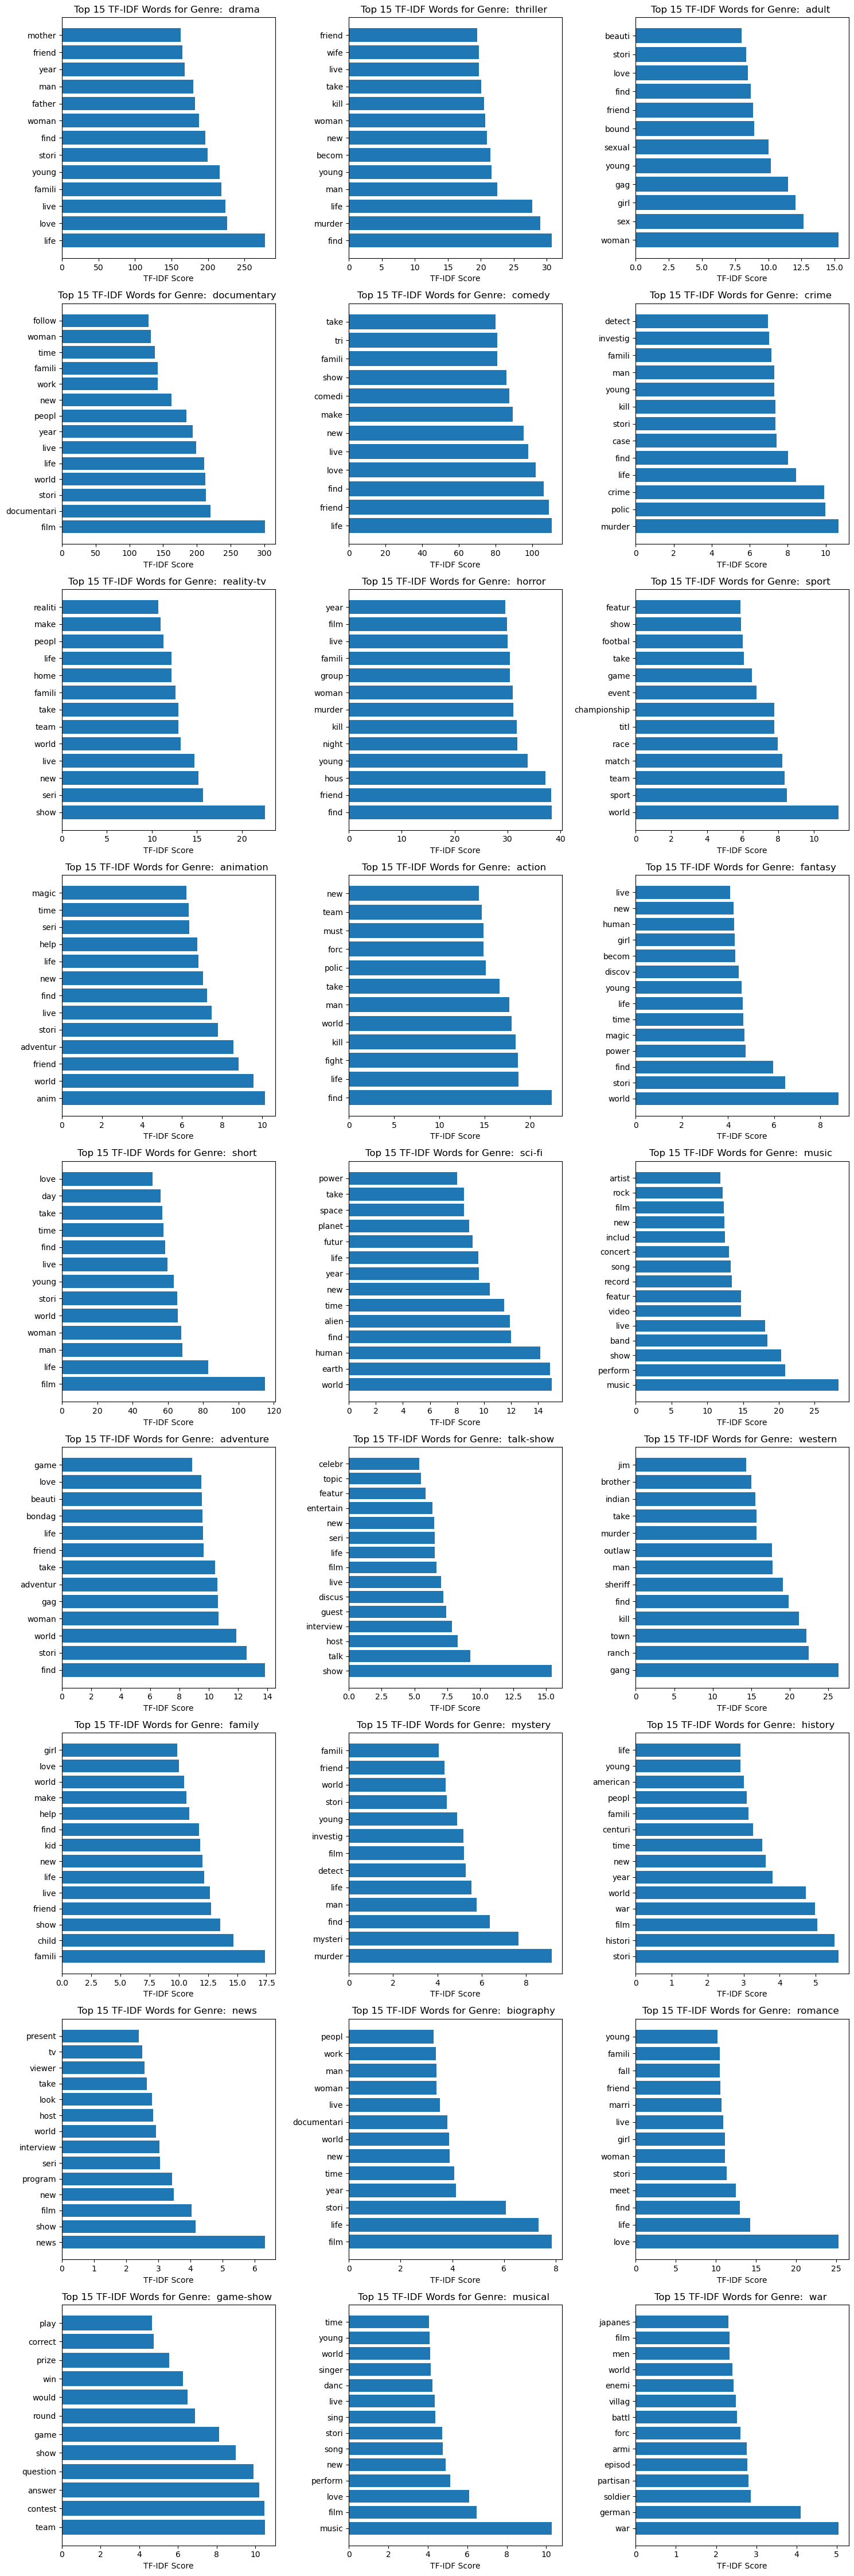

In [29]:

# Words to exclude
exclude_words = ['one','two','first', 'three', 'us', 'get']

# Assuming you have a 'genre' column in your dataframe
genres = data['GENRE'].unique()

# Initialize a dictionary to store TF-IDF scores for each genre
genre_tfidf = {}

# Initialize subplots
num_genres = len(genres)
num_cols = 3
num_rows = (num_genres // num_cols) + (1 if num_genres % num_cols != 0 else 0)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Iterate over each genre
for i, genre in enumerate(genres):
    # Filter data for the current genre
    genre_data = data[data['GENRE'] == genre]
    
    # Initialize TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer()
    
    # Fit and transform description for the current genre
    tfidf_features = tfidf_vectorizer.fit_transform(genre_data['processed_description'])
    
    # Get feature names
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    # Sum TF-IDF scores for each feature across all documents
    tfidf_scores = tfidf_features.sum(axis=0).A1
    
    # Create a dictionary with feature names as keys and TF-IDF scores as values
    genre_tfidf[genre] = dict(zip(feature_names, tfidf_scores))
    
    # Get top 15 words and their TF-IDF scores for the current genre
    top_words = sorted(genre_tfidf[genre].items(), key=lambda x: x[1], reverse=True)[:15]
    words, scores = zip(*top_words)
    
    # Remove excluded words
    words = [word for word in words if word not in exclude_words]
    scores = [score for word, score in top_words if word not in exclude_words]
    
    # Plot
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]
    ax.barh(range(len(words)), scores, align='center')
    ax.set_yticks(range(len(words)))
    ax.set_yticklabels(words)
    ax.set_xlabel('TF-IDF Score')
    ax.set_title(f'Top 15 TF-IDF Words for Genre: {genre}')

# Remove empty subplots
for i in range(num_genres, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]
    ax.axis('off')
plt.tight_layout()
plt.show()
    
   

### APPLY THE BAG OF WORDS ON THE DATA:

In [30]:
# Words to exclude
exclude_words = ['one','two','first', 'three', 'us', 'get']

# Assuming you have a 'genre' column in your dataframe
genres = data['GENRE'].unique()

# Initialize a dictionary to store Bag of Words counts for each genre
genre_bow = {}

# Iterate over each genre
for genre in genres:
    # Filter data for the current genre
    genre_data = data[data['GENRE'] == genre]
    
    # Join the tokenized words back into sentences
    genre_data['processed_description2'] = genre_data['LEMMATIZED_DESCRIPTION'].apply(lambda x: ' '.join(x))
    
    # Initialize the CountVectorizer with excluded words
    count_vectorizer = CountVectorizer(stop_words=exclude_words)
    
    # Fit and transform the processed descriptions to get Bag of Words features
    bow_features = count_vectorizer.fit_transform(genre_data['processed_description2'])
    
    # Get feature names
    feature_names = count_vectorizer.get_feature_names_out()
    
    # Sum the Bag of Words counts for each feature across all documents
    bow_counts = bow_features.sum(axis=0).A1
    
    # Create a dictionary with feature names as keys and Bag of Words counts as values
    genre_bow[genre] = dict(zip(feature_names, bow_counts))

# Now, genre_bow contains Bag of Words counts for each genre
# You can use this dictionary for plotting or further analysis

/var/folders/nm/b7tk3rjx5vnb02jr8x3zr64r0000gn/T/ipykernel_4447/4022042328.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genre_data['processed_description2'] = genre_data['LEMMATIZED_DESCRIPTION'].apply(lambda x: ' '.join(x))
/var/folders/nm/b7tk3rjx5vnb02jr8x3zr64r0000gn/T/ipykernel_4447/4022042328.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genre_data['processed_description2'] = genre_data['LEMMATIZED_DESCRIPTION'].apply(lambda x: ' '.join(x))
/var/folders/nm/b7tk3rjx5vnb02jr8x3zr64r0000gn

/var/folders/nm/b7tk3rjx5vnb02jr8x3zr64r0000gn/T/ipykernel_4447/4022042328.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genre_data['processed_description2'] = genre_data['LEMMATIZED_DESCRIPTION'].apply(lambda x: ' '.join(x))
/var/folders/nm/b7tk3rjx5vnb02jr8x3zr64r0000gn/T/ipykernel_4447/4022042328.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genre_data['processed_description2'] = genre_data['LEMMATIZED_DESCRIPTION'].apply(lambda x: ' '.join(x))
/var/folders/nm/b7tk3rjx5vnb02jr8x3zr64r0000gn

## Plot the top words of each GENRE

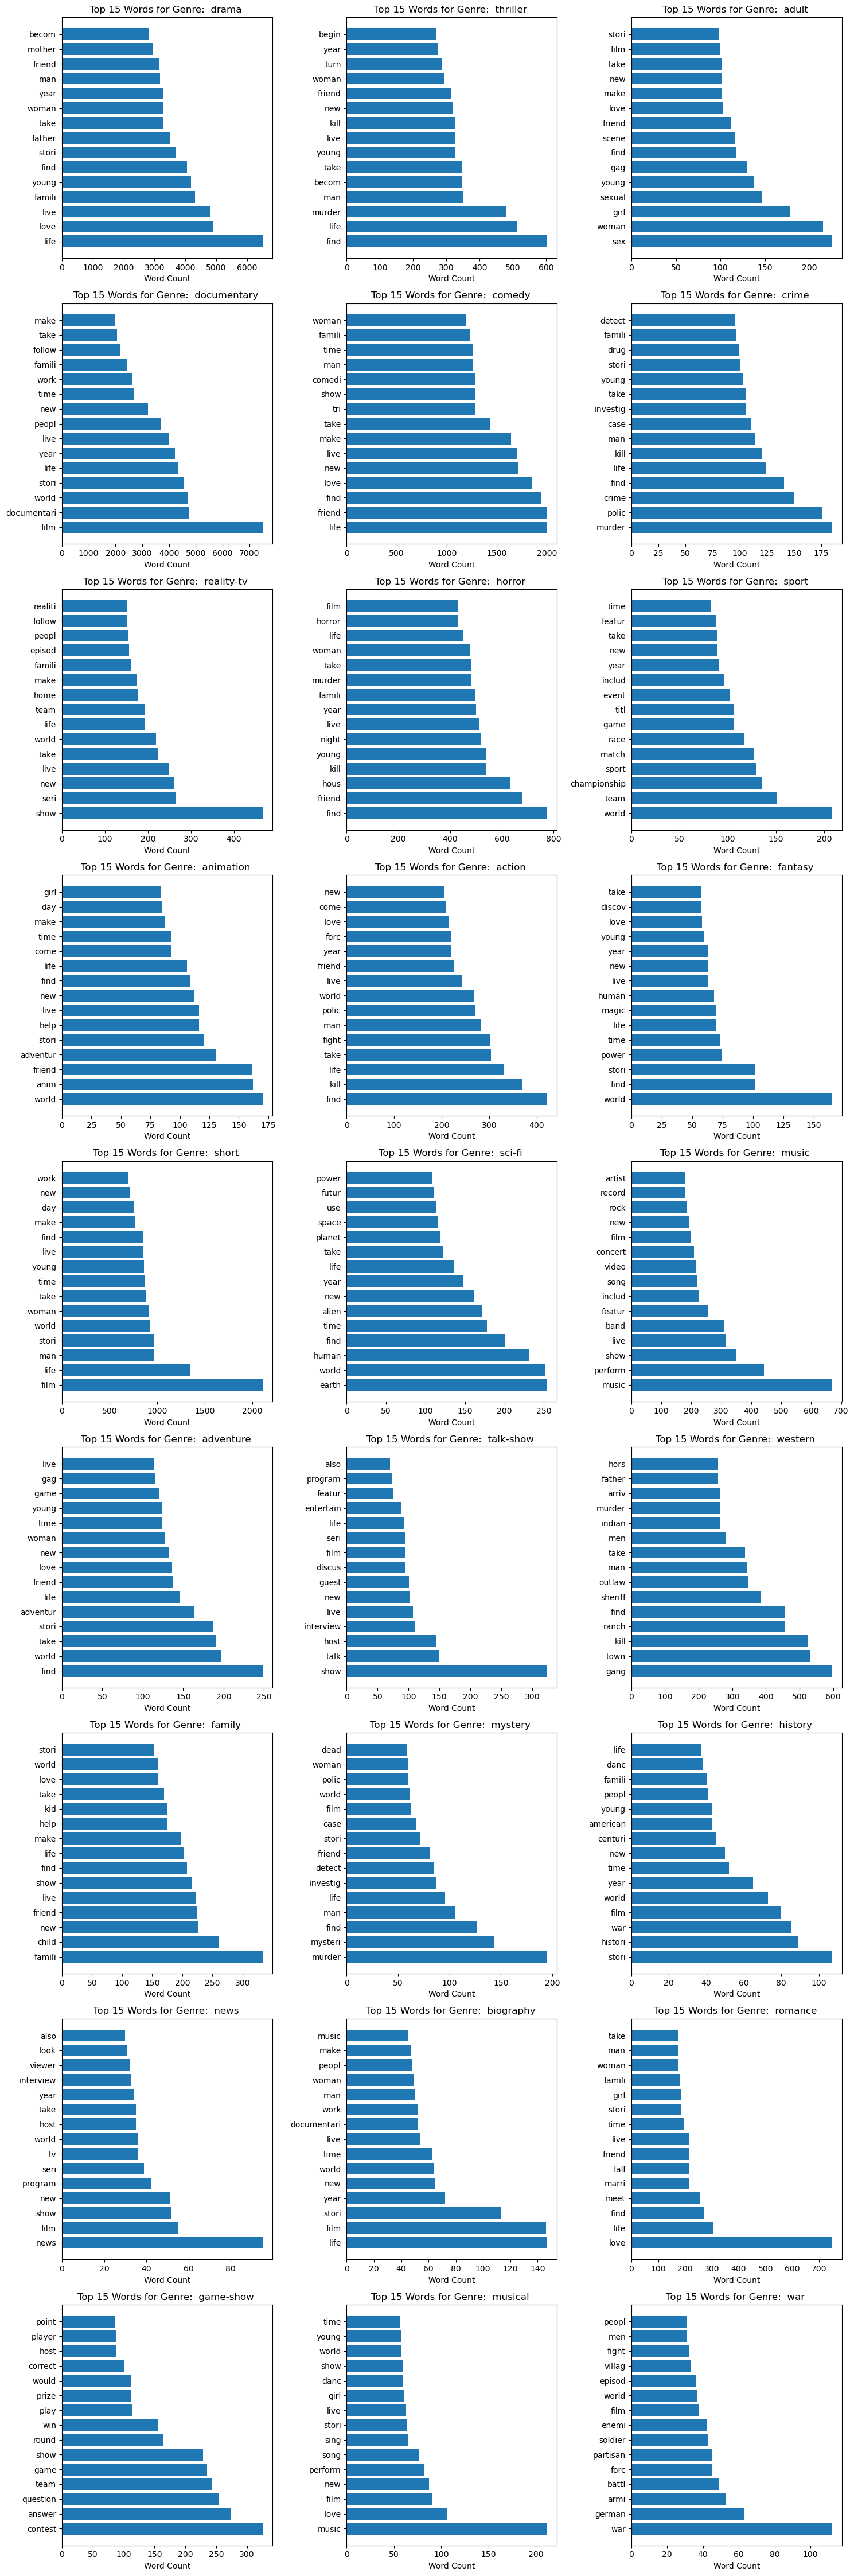

In [31]:
# Initialize subplots
num_genres = len(genres)
num_cols = 3
num_rows = (num_genres // num_cols) + (1 if num_genres % num_cols != 0 else 0)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Iterate over each genre
for i, genre in enumerate(genres):
    # Get Bag of Words counts for the current genre
    bow_counts = genre_bow[genre]
    
    # Sort the dictionary by value (word counts)
    sorted_bow_counts = sorted(bow_counts.items(), key=lambda x: x[1], reverse=True)
    
    # Get top 15 words and their counts for the current genre
    top_words = sorted_bow_counts[:15]
    words, counts = zip(*top_words)
    
    # Plot
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]
    ax.barh(range(len(words)), counts, align='center')
    ax.set_yticks(range(len(words)))
    ax.set_yticklabels(words)
    ax.set_xlabel('Word Count')
    ax.set_title(f'Top 15 Words for Genre: {genre}')

# Remove empty subplots
for i in range(num_genres, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]
    ax.axis('off')

plt.tight_layout()
plt.show()



# Modeling

## Label Encoding: encode the target variable 'genre':

In [32]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode the 'GENRE' column
data['GENRE_ENCODED'] = label_encoder.fit_transform(data['GENRE'])

# Store the mapping for later use if needed
genre_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))


### Print the unique genres along with their encodings

In [33]:
# Print the unique genres along with their encodings
for genre, encoding in genre_mapping.items():
    print(f"{genre}: {encoding}")


 action : 0
 adult : 1
 adventure : 2
 animation : 3
 biography : 4
 comedy : 5
 crime : 6
 documentary : 7
 drama : 8
 family : 9
 fantasy : 10
 game-show : 11
 history : 12
 horror : 13
 music : 14
 musical : 15
 mystery : 16
 news : 17
 reality-tv : 18
 romance : 19
 sci-fi : 20
 short : 21
 sport : 22
 talk-show : 23
 thriller : 24
 war : 25
 western : 26


In [34]:
data.head(3)

,ID,TITLE,GENRE,DESCRIPTION,CLEAN_DESCRIPTION,TOKENIZED_DESCRIPTION,STEMMED_DESCRIPTION,LEMMATIZED_DESCRIPTION,processed_description,GENRE_ENCODED
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,listening in to a conversation between his do...,"[listening, conversation, doctor, parents, 10y...","[listen, convers, doctor, parent, 10yearold, o...","[listen, convers, doctor, parent, 10yearold, o...",listen convers doctor parent 10yearold oscar l...,8
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,a brother and sister with a past incestuous r...,"[brother, sister, past, incestuous, relationsh...","[brother, sister, past, incestu, relationship,...","[brother, sister, past, incestu, relationship,...",brother sister past incestu relationship curre...,24
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,as the bus empties the students for their fie...,"[bus, empties, students, field, trip, museum, ...","[bus, empti, student, field, trip, museum, nat...","[bus, empti, student, field, trip, museum, nat...",bus empti student field trip museum natur hist...,1


## Splitting Data

80% of your data will be used for training (X_train and y_train), and 20% will be used for validation (X_val and y_val).

In [35]:
# Split the data into training and validation sets

from sklearn.model_selection import train_test_split
# Step 1: Spliting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    data['processed_description'],
    data['GENRE_ENCODED'],
    test_size=0.2, 
    random_state=42
)
# Step 2: Loading the separate test file
dataset_path = 'data/test_data_preprocessed_with_target.txt'
test_data = pd.read_csv(dataset_path, sep='/', engine='python', header=None)
test_data.columns = ['ID', 'TITLE', 'processed_description', 'GENRE_ENCODED_TEST']

# Step 3: Preparing features for the test set
X_test = test_data['processed_description']

# Test data labels
y_test = test_data['GENRE_ENCODED_TEST']

In [36]:
print("TF-IDF Features Shape:", tfidf_features.shape)
print("Target Variable Shape:", data['GENRE_ENCODED'].shape)

TF-IDF Features Shape: (132, 2684)
Target Variable Shape: (54214,)


# Random Forest Model

In [37]:
# Create a TF-IDF Vectorizer and Random Forest classifier pipeline
rf_model_pipeline = make_pipeline(TfidfVectorizer(), RandomForestClassifier(n_estimators=100, random_state=42))

# Train the model on the training set
rf_model_pipeline.fit(X_train, y_train)

# Predict on the validation set
y_val_pred_rf = rf_model_pipeline.predict(X_val)

# Evaluate the model's performance on the validation set
print("Validation Set Accuracy:", accuracy_score(y_val, y_val_pred_rf))
print("Validation Set Classification Report:\n", classification_report(y_val, y_val_pred_rf))

# Optionally, you can also predict on the test set and evaluate
y_test_pred_rf = rf_model_pipeline.predict(X_test)
print("Test Set Accuracy:", accuracy_score(y_test, y_test_pred_rf))
print("Test Set Classification Report:\n", classification_report(y_test, y_test_pred_rf))


Validation Set Accuracy: 0.48685788066033386
Validation Set Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       263
           1       1.00      0.06      0.12       112
           2       0.55      0.08      0.14       139
           3       0.00      0.00      0.00       104
           4       0.00      0.00      0.00        61
           5       0.56      0.27      0.37      1443
           6       1.00      0.01      0.02       107
           7       0.55      0.88      0.67      2659
           8       0.42      0.85      0.56      2697
           9       1.00      0.03      0.05       150
          10       0.00      0.00      0.00        74
          11       0.92      0.30      0.45        40
          12       0.00      0.00      0.00        45
          13       0.79      0.10      0.17       431
          14       0.94      0.10      0.19       144
          15       0.00      0.00      0.00        

/Users/lilia/opt/anaconda3/envs/DM_ENV/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lilia/opt/anaconda3/envs/DM_ENV/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lilia/opt/anaconda3/envs/DM_ENV/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Test Set Accuracy: 0.47987084870848706
Test Set Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.01      0.01      1314
           1       0.79      0.06      0.10       590
           2       0.84      0.10      0.17       775
           3       0.25      0.00      0.00       498
           4       0.00      0.00      0.00       264
           5       0.53      0.25      0.34      7446
           6       1.00      0.00      0.00       505
           7       0.54      0.88      0.67     13096
           8       0.41      0.84      0.55     13612
           9       0.90      0.01      0.02       783
          10       0.00      0.00      0.00       322
          11       0.93      0.44      0.59       193
          12       0.00      0.00      0.00       243
          13       0.75      0.09      0.15      2204
          14       0.86      0.08      0.15       731
          15       0.43      0.02      0.04       276
         

/Users/lilia/opt/anaconda3/envs/DM_ENV/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lilia/opt/anaconda3/envs/DM_ENV/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lilia/opt/anaconda3/envs/DM_ENV/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

# Gradient Boosting

In [38]:
xgb_model_pipeline = make_pipeline(TfidfVectorizer(), XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))

# Train the model on the training set
xgb_model_pipeline.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = xgb_model_pipeline.predict(X_val)

# Evaluate the model's performance on the validation set
print("Validation Set Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation Set Classification Report:\n", classification_report(y_val, y_val_pred))

# Optionally, you can also predict on the test set and evaluate
y_test_pred = xgb_model_pipeline.predict(X_test)
print("Test Set Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test Set Classification Report:\n", classification_report(y_test, y_test_pred))

Validation Set Accuracy: 0.5471732915244858
Validation Set Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.20      0.28       263
           1       0.67      0.38      0.48       112
           2       0.34      0.17      0.23       139
           3       0.42      0.12      0.19       104
           4       0.00      0.00      0.00        61
           5       0.51      0.48      0.49      1443
           6       0.27      0.06      0.09       107
           7       0.65      0.79      0.71      2659
           8       0.50      0.76      0.60      2697
           9       0.44      0.14      0.21       150
          10       0.20      0.03      0.05        74
          11       0.83      0.50      0.62        40
          12       0.00      0.00      0.00        45
          13       0.60      0.53      0.56       431
          14       0.58      0.49      0.53       144
          15       0.33      0.06      0.10        5

/Users/lilia/opt/anaconda3/envs/DM_ENV/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lilia/opt/anaconda3/envs/DM_ENV/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lilia/opt/anaconda3/envs/DM_ENV/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Test Set Accuracy: 0.5436162361623617
Test Set Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.21      0.28      1314
           1       0.58      0.31      0.40       590
           2       0.48      0.18      0.26       775
           3       0.32      0.10      0.15       498
           4       0.00      0.00      0.00       264
           5       0.52      0.49      0.50      7446
           6       0.17      0.04      0.07       505
           7       0.65      0.79      0.71     13096
           8       0.49      0.75      0.59     13612
           9       0.37      0.07      0.12       783
          10       0.28      0.03      0.05       322
          11       0.82      0.54      0.65       193
          12       0.33      0.01      0.02       243
          13       0.60      0.52      0.56      2204
          14       0.60      0.48      0.53       731
          15       0.13      0.02      0.03       276
          

# SVC MODEL

In [39]:
# Create a pipeline with TF-IDF vectorization and SVC
svc_pipeline = make_pipeline(TfidfVectorizer(), SVC(kernel='linear'))

# Train the SVC model on the training data
svc_pipeline.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = svc_pipeline.predict(X_val)

# Evaluate the model's performance
print("Validation Set Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation Set Classification Report:\n", classification_report(y_val, y_val_pred))


Validation Set Accuracy: 0.5942082449506594
Validation Set Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.35      0.41       263
           1       0.74      0.45      0.56       112
           2       0.41      0.19      0.26       139
           3       0.52      0.14      0.23       104
           4       0.00      0.00      0.00        61
           5       0.53      0.61      0.57      1443
           6       0.36      0.04      0.07       107
           7       0.68      0.83      0.75      2659
           8       0.55      0.77      0.64      2697
           9       0.38      0.09      0.15       150
          10       0.67      0.05      0.10        74
          11       0.87      0.50      0.63        40
          12       0.00      0.00      0.00        45
          13       0.66      0.65      0.66       431
          14       0.65      0.53      0.59       144
          15       0.33      0.02      0.04        5

/Users/lilia/opt/anaconda3/envs/DM_ENV/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lilia/opt/anaconda3/envs/DM_ENV/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lilia/opt/anaconda3/envs/DM_ENV/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_